In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from helpers import *
%load_ext autoreload
%autoreload 2

In [2]:
data_path = 'train.csv'
y_raw, x_raw, ids = load_csv_data(data_path, True)

# Math functions

In [587]:
f_mse = lambda y,x,w: 1/(2*len(y))*LA.norm(y-x.dot(w))**2
gradf_mse = lambda y,x,w: -1/len(y)*x.T.dot(y-x.dot(w))
sigmoid = lambda x: 1./(1.+np.exp(-x))
f_logistic = lambda y,x,w: -np.sum(np.log(sigmoid(y*np.dot(x,w))), axis=0)/len(y)
gradf_logistic = lambda y,x,w: (-x.T.dot((1. - sigmoid(y*(x.dot(w)))) * y))/len(y)

# functions 

In [606]:
def clean(x):
    '''replace -999 by mean of the rest'''
    for i in range(len(x[0])):
        tmp = x[:,i]
        tmp[tmp == -999] = np.mean(tmp[tmp != -999])
        x[:,i] = tmp
    return x

In [607]:
def std(x, mean, stdv):
    for i in range(1, len(x[0])):
        x[:,i] = (x[:,i] - mean[i])/stdv[i]
    return x

In [608]:
def addcolumn(x,f):
    for i in range(len(f)):
        for j in range(d):
            x = np.concatenate((x, f[i](x[:,j]).reshape(-1,1)), axis = 1)
    x = np.concatenate((np.ones((len(x[:,0]),1)), x), axis = 1)
    return x

In [609]:
def preprocess(y_in, x_in, mask, f):
    '''apply mask --> clean --> std --> for each parameter x[:,i] and each f[j], add 1 column f[j](x[:,i]) 
    --> add column "1" to the left'''
    x = clean(x_in[:, mask])
    yx = np.concatenate((y_in, x), axis = 1)
    np.random.shuffle(yx)
    y = yx[:,0]
    x = yx[:,1:]
    x = addcolumn(x,f)
    return y, x

In [610]:
def split(y, x):
    '''reshape x_in, y_in into K subsets of size (N//K) x d'''
    return y.reshape(K, N//K, 1), x.reshape(K, N//K, D)

In [658]:
def get_train_test(y_in, x_in, k, train_more):
    #define a mask to filter out the k-th element 
    no_k = np.ones(K, dtype = bool)
    no_k[k] = False
    
    x = x_in[k]
    y = y_in[k]
    x_rest = x_in[no_k].reshape(N - N//K, D)
    y_rest = y_in[no_k].reshape(N-N//K, 1)
    m = np.mean(x, axis = 0)
    m_rest = np.mean(x_rest, axis = 0)
    s = np.std(x, axis = 0)
    s_rest = np.std(x_rest, axis = 0)
    print(np.max(abs(m_rest-m)))
    print(np.max(abs(s_rest-s)))
    if train_more == True:
        mean = m_rest
        stdv = s_rest
        return y_rest, y, std(x_rest, mean, stdv), std(x, mean, stdv)
    else:
        mean = m
        stdv = s
        return y, y_rest, std(x, mean, stdv), std(x_rest, mean, stdv)

In [659]:
def get_stsize(y, x, w, f, gradf):
    sts = 1/(0.0000005*np.max(np.linalg.eig(x.T.dot(x))[0]))
    a = gradf(y, x, w)
    b = f(y, x, w)
    c = LA.norm(gradf(y, x, w))**2
    while f(y, x, w - sts*a) > b - sts/2*c:
        sts = sts * beta
        #if sts < 1/(1*np.max(np.linalg.eig(x.T.dot(x))[0])): return sts
        #print(sts)
    #print('\n')
    return sts

In [660]:
def GD(y, x, w0, st_size, f, gradf):
    w = np.zeros((n_iter+1,D,1))
    L = np.zeros(n_iter+1)
    w[0] = w0
    L[0] = f(y,x,w[0])
    for i in range(n_iter):
        st_size = get_stsize(y,x,w[i], f, gradf)
        w[i+1] = w[i] - st_size*gradf(y, x, w[i])
        L[i+1] = f(y,x,w[i])
    return w, L

In [661]:
def SGD(y, x, w0, st_size, f, gradf):
    w = np.zeros((n_iter+1, D,1))
    L = np.zeros(n_iter+1)
    w[0] = w0
    window = np.random.randint(0, len(y), size=1)
    L[0] = f(y[window],x[window],w[0])
    #st_size = 1/(np.max(np.linalg.eig(x.T.dot(x))[0]))
    for i in range(n_iter):
        #define filter
        window = np.random.randint(0, len(y), size=1)
        #line search st size
        #st_size = get_stsize(y[window],x[window],w[i], f, gradf) adaptive stepsize is not useful for SGD
        w[i+1] = w[i] - st_size*gradf(y[window], x[window], w[i])
        L[i+1] = f(y[window],x[window],w[i])
    return w, L

In [662]:
def train(mod, alg, y, x, w0):
    f, gradf, st_size = model_train[mod]
    return alg(y, x, w0, st_size, f, gradf)


# Initialization

In [663]:
#set mask to filter out parameters that wont be used
mask = np.ones(len(x_raw[0]), dtype=bool)
mark = [] #np.array([0,4,5,6,9,11,12,15,18,20,23,24,25,26,27,28,29]) #############
mask [mark] = False
#set model functions (Ex: higher order regression,...)
model_func = [
              ]

#set training model (EX: logistic, mse,...)
model_train = {'logistic':(f_logistic, gradf_logistic, 0.001), #0.05 for GD of subsample, 0.001 for SGD subsample
               'mse':(f_mse, gradf_mse, 0.0002)} # 0.01 for GD subsample, 0.0002 for SGD subsampple

d = np.sum(mask) #number of original parameter used
N = len(y_raw)
K = 5 #K>=2
beta = 0.5 #parameter to reduce stepsize in backtracking line search st=st*beta
train_more = True
print(d)

30


In [664]:
x_raw = x_raw.reshape(N, 30)
y_raw = y_raw.reshape(N, 1)
y_full, x_full = preprocess(y_raw, x_raw, mask, model_func)
D = len(x_full[0]) #number of total parameter

In [665]:
ys, xs = split(y_full.copy(), x_full.copy())

In [672]:
n_iter = 500
w0 = np.zeros((D,1))
wf = np.zeros((K, n_iter+1, D))
Lf = np.zeros((K, n_iter+1))
acc = np.zeros((K, n_iter+1))

In [673]:
#test
y, yt, x, xt = get_train_test(ys, xs, 0, train_more)
#print(np.std(x,axis =0))
# stst = 1/(0.0000005*np.max(np.linalg.eig(x.T.dot(x))[0]))
# print(stst)
# a = f_logistic(y, x, w0 - stst*gradf_logistic(y, x, w0))
# b = f_logistic(y, x, w0)
# c = LA.norm(gradf_logistic(y, x, w0))**2
# print(a>b-stst/2*c)
print(x_full.shape)
print(np.max(abs(np.std(xt, axis = 0))))

366.44689276332423
457.8485973885982
(5000, 31)
2111.2007241683673


# Main

1242.5723096179815
2110.983754952053
running0-th batch
1431.8634666234564
5460.637161579216
running1-th batch
1431.903521456484
5460.619261841441
running2-th batch
1431.948916486408
5460.604397674876
running3-th batch
1432.0285236820212
5460.591681724721
running4-th batch
done


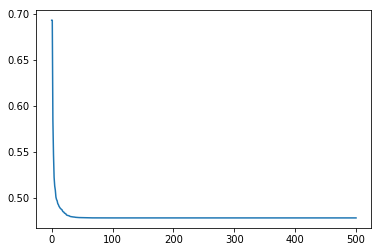

In [674]:
for i in range(K):
    y, yt, x, xt = get_train_test(ys, xs, i, train_more)
    tmp_wf, Lf[i] = train('logistic', GD, y, x, w0) ##################
    wf[i] = tmp_wf.reshape(n_iter+1,D)
    print('running'+ str(i) +'-th batch')
    for j in range(n_iter+1):
        acc[i,j] = np.sum(np.sign(xt.dot(wf[i,j]).reshape(-1,1)) == yt)/len(yt)*100
print('done')
plt.plot(Lf[0])
#acc: else
#acc1: mse GD 5k iter, fixed stsize
#acc2: mse SGD 5k iter
#acc3: logistic GD 5k iter, fixed stsize
#acc4: logistic SGD 5k iter
#acc5: mse, SGD 50k iter 
#acc6: logistic, SGD 50k iter
#acc7: mse, GD 500 iter, adapt stsize
#acc8: logistic, GD 500 iter, adapt stsize
#acc9: logistic, GD 500 iter, adapt stsize, 

64.64
12.841900170924859


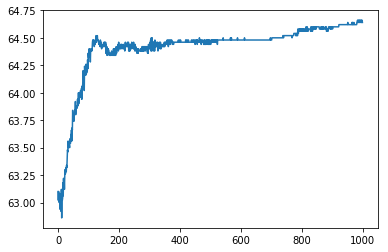

In [642]:
#acc9 = acc.copy()
plt.plot(np.mean(acc[:,1:], axis = 0))
print(np.mean(acc[:, n_iter]))
print(np.std(acc[:, n_iter]))

# output

74.78
1.0283968105745958
75.0
0.9633275663033856


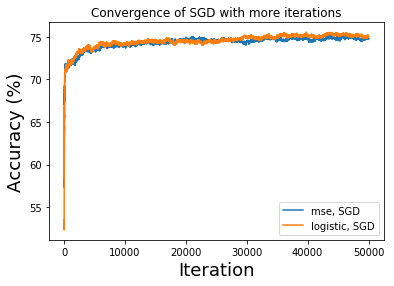

In [453]:
xplot = np.arange(0, n_iter, 1)
y5plot = np.mean(acc5[:,1:], axis = 0)
y6plot = np.mean(acc6[:,1:], axis = 0)
plt.plot(xplot, y5plot, xplot, y6plot)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend(('mse, SGD', 'logistic, SGD'), loc = 'lower right')
plt.title('Convergence of SGD with more iterations')
print(np.mean(acc5[:, n_iter]))
print(np.std(acc5[:, n_iter]))
print(np.mean(acc6[:, n_iter]))
print(np.std(acc6[:, n_iter]))

75.1
0.7456540752922918
75.41999999999999
0.810925397308531


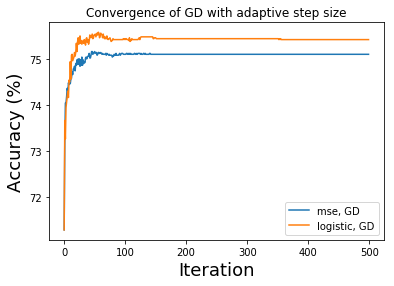

In [473]:
xplot = np.arange(0, n_iter, 1)
y7plot = np.mean(acc7[:,1:], axis = 0)
y8plot = np.mean(acc8[:,1:], axis = 0)
plt.plot(xplot, y7plot, xplot, y8plot)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend(('mse, GD', 'logistic, GD'), loc = 'lower right')
plt.title('Convergence of GD with adaptive step size')
print(np.mean(acc7[:, n_iter]))
print(np.std(acc7[:, n_iter]))
print(np.mean(acc8[:, n_iter]))
print(np.std(acc8[:, n_iter]))

75.12
0.7807688518377245
74.05999999999999
1.6463292501805349
75.52
1.2890306435457624
73.88
1.0851727973000436


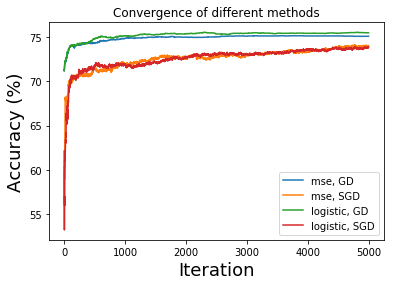

In [466]:
xplot = np.arange(0, n_iter, 1)
y1plot = np.mean(acc1[:,1:], axis = 0)
y2plot = np.mean(acc2[:,1:], axis = 0)
y3plot = np.mean(acc3[:,1:], axis = 0)
y4plot = np.mean(acc4[:,1:], axis = 0)
lines = plt.plot(xplot, y1plot, xplot, y2plot, xplot, y3plot, xplot, y4plot)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend(('mse, GD', 'mse, SGD', 'logistic, GD', 'logistic, SGD'), loc = 'lower right')
plt.title('Convergence of different methods')

print(np.mean(acc1[:, n_iter]))
print(np.std(acc1[:, n_iter]))

print(np.mean(acc2[:, n_iter]))
print(np.std(acc2[:, n_iter]))

print(np.mean(acc3[:, n_iter]))
print(np.std(acc8[:, n_iter]))

print(np.mean(acc4[:, n_iter]))
print(np.std(acc4[:, n_iter]))

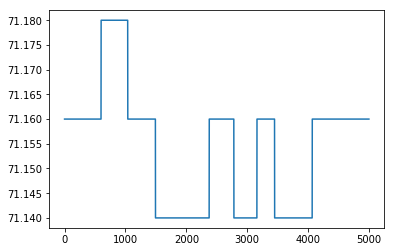

In [339]:
plt.plot(y1plot)

# run with test.csv

In [102]:
i_f = np.max(np.where(acc == np.max(acc)))
print(i_f)
wff = wf[i_f, n_iter]
print(wff)

0
[-9.84140723e-02  4.58239172e-01 -7.30382342e-01  1.99142575e-01
  1.80603476e-01  4.75670054e-02 -4.79674211e-02 -3.07485528e-02
  3.31053536e-01 -8.20673475e-02  2.36575410e-01 -3.49399733e-01
  8.96774699e-02  4.95859905e-02  6.86877463e-01  9.87356159e-02
  1.94838092e-02  3.33334903e-01  7.69459962e-02  5.85609227e-02
 -6.90335309e-02 -7.73512928e-02  5.49128197e-02 -4.38119534e-02
  2.25987981e-01 -1.28999958e-01  2.05680223e-02  8.52140526e-03
 -7.66568132e-03 -1.69440125e-03  6.21003777e-02 -7.65043950e-01
  1.09173397e-02 -7.32555435e-01  2.82314997e-01  8.39167472e-02
 -4.31997526e-03  3.03982693e-02 -3.11925788e-01  1.44244147e-01
 -1.29211749e-01  3.03113454e-02  1.53575580e-01 -1.28315598e-02
 -8.55966896e-02 -1.23071691e-01 -4.72561785e-02  1.03796562e-01
 -2.11210075e-01 -4.92799667e-02  1.86624274e-01  1.42154398e-02
 -2.04191477e-01 -4.56303925e-02 -1.67849057e-01  1.66462102e-01
 -8.61917287e-02  5.63413996e-02  8.16372200e-02 -2.07660703e-02
 -9.21678017e-02 -1.843

In [38]:
y_test_raw, x_test_raw, ids_test = load_csv_data('test.csv')

In [103]:
n_test = len(y_test_raw)
print(n_test)
x_test = x_test_raw.reshape(n_test, len(x_test_raw[0]))
y_test = y_test_raw.reshape(n_test, 1)
print(x_test.shape)
y_tt, x_tt = preprocess(y_test.copy(), x_test.copy(), mask, model_func)

568238
(568238, 30)


In [104]:
print(wff)
print(np.sum(np.sign(x_tt.dot(wff)) == 1)*100/n_test)

[-9.84140723e-02  4.58239172e-01 -7.30382342e-01  1.99142575e-01
  1.80603476e-01  4.75670054e-02 -4.79674211e-02 -3.07485528e-02
  3.31053536e-01 -8.20673475e-02  2.36575410e-01 -3.49399733e-01
  8.96774699e-02  4.95859905e-02  6.86877463e-01  9.87356159e-02
  1.94838092e-02  3.33334903e-01  7.69459962e-02  5.85609227e-02
 -6.90335309e-02 -7.73512928e-02  5.49128197e-02 -4.38119534e-02
  2.25987981e-01 -1.28999958e-01  2.05680223e-02  8.52140526e-03
 -7.66568132e-03 -1.69440125e-03  6.21003777e-02 -7.65043950e-01
  1.09173397e-02 -7.32555435e-01  2.82314997e-01  8.39167472e-02
 -4.31997526e-03  3.03982693e-02 -3.11925788e-01  1.44244147e-01
 -1.29211749e-01  3.03113454e-02  1.53575580e-01 -1.28315598e-02
 -8.55966896e-02 -1.23071691e-01 -4.72561785e-02  1.03796562e-01
 -2.11210075e-01 -4.92799667e-02  1.86624274e-01  1.42154398e-02
 -2.04191477e-01 -4.56303925e-02 -1.67849057e-01  1.66462102e-01
 -8.61917287e-02  5.63413996e-02  8.16372200e-02 -2.07660703e-02
 -9.21678017e-02 -1.84348

In [105]:
create_csv_submission(ids_test, predict_labels(wff,x_tt), 'how_bad_can_it_get.csv')